In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

color_mapping12 = {
    "C>A": "deepskyblue",
    "G>T": "deepskyblue",
    "C>G": "black",
    "G>C": "black",
    "C>T": "red",
    "G>A": "red",
    "T>A": "silver",
    "A>T": "silver",
    "T>C": "yellowgreen",
    "A>G": "yellowgreen",
    "T>G": "pink",
    "A>C": "pink",
}

In [2]:
spectra = pd.read_csv('./data/viral_spectra_dataset.csv').sort_values(['Type', 'G>T'])
spectra.loc[spectra.taxname.str.len() > 25, 'taxname'] = spectra.loc[spectra.taxname.str.len() > 25, 'virusname']

spectra_long = spectra.melt(['taxname', 'Type', 'virusname', 'df', 'taxid'], var_name='Mut', value_name='MutSpec')
spectra_long['label'] = spectra_long.taxname.str[:25] + ' (' + spectra_long.Type + ')'
spectra_long

,taxname,Type,virusname,df,taxid,Mut,MutSpec,label
0,Hepacivirus hominis,+,HCV,nemu,3052230,A>C,0.020028,Hepacivirus hominis (+)
1,Enterovirus D,+,evD,nemu,138951,A>C,0.003839,Enterovirus D (+)
2,Dengue virus,+,denv,nemu,12637,A>C,0.007133,Dengue virus (+)
3,Enterovirus A,+,evA,nemu,138948,A>C,0.004868,Enterovirus A (+)
4,FMDV,+,FMDV,nemu,12110,A>C,0.012652,FMDV (+)
...,...,...,...,...,...,...,...,...
439,Piscine orthoreovirus,ds,PRV,nemu,1157337,T>G,0.000000,Piscine orthoreovirus (ds)
440,Mammalian orthoreovirus,ds,MRV,nemu,351073,T>G,0.025175,Mammalian orthoreovirus (ds)
441,Avian orthoreovirus,ds,aorv,nemu,38170,T>G,0.024043,Avian orthoreovirus (ds)
442,Banna virus,ds,BAV,nemu,77763,T>G,0.016398,Banna virus (ds)


In [3]:
import warnings
warnings.filterwarnings("ignore")

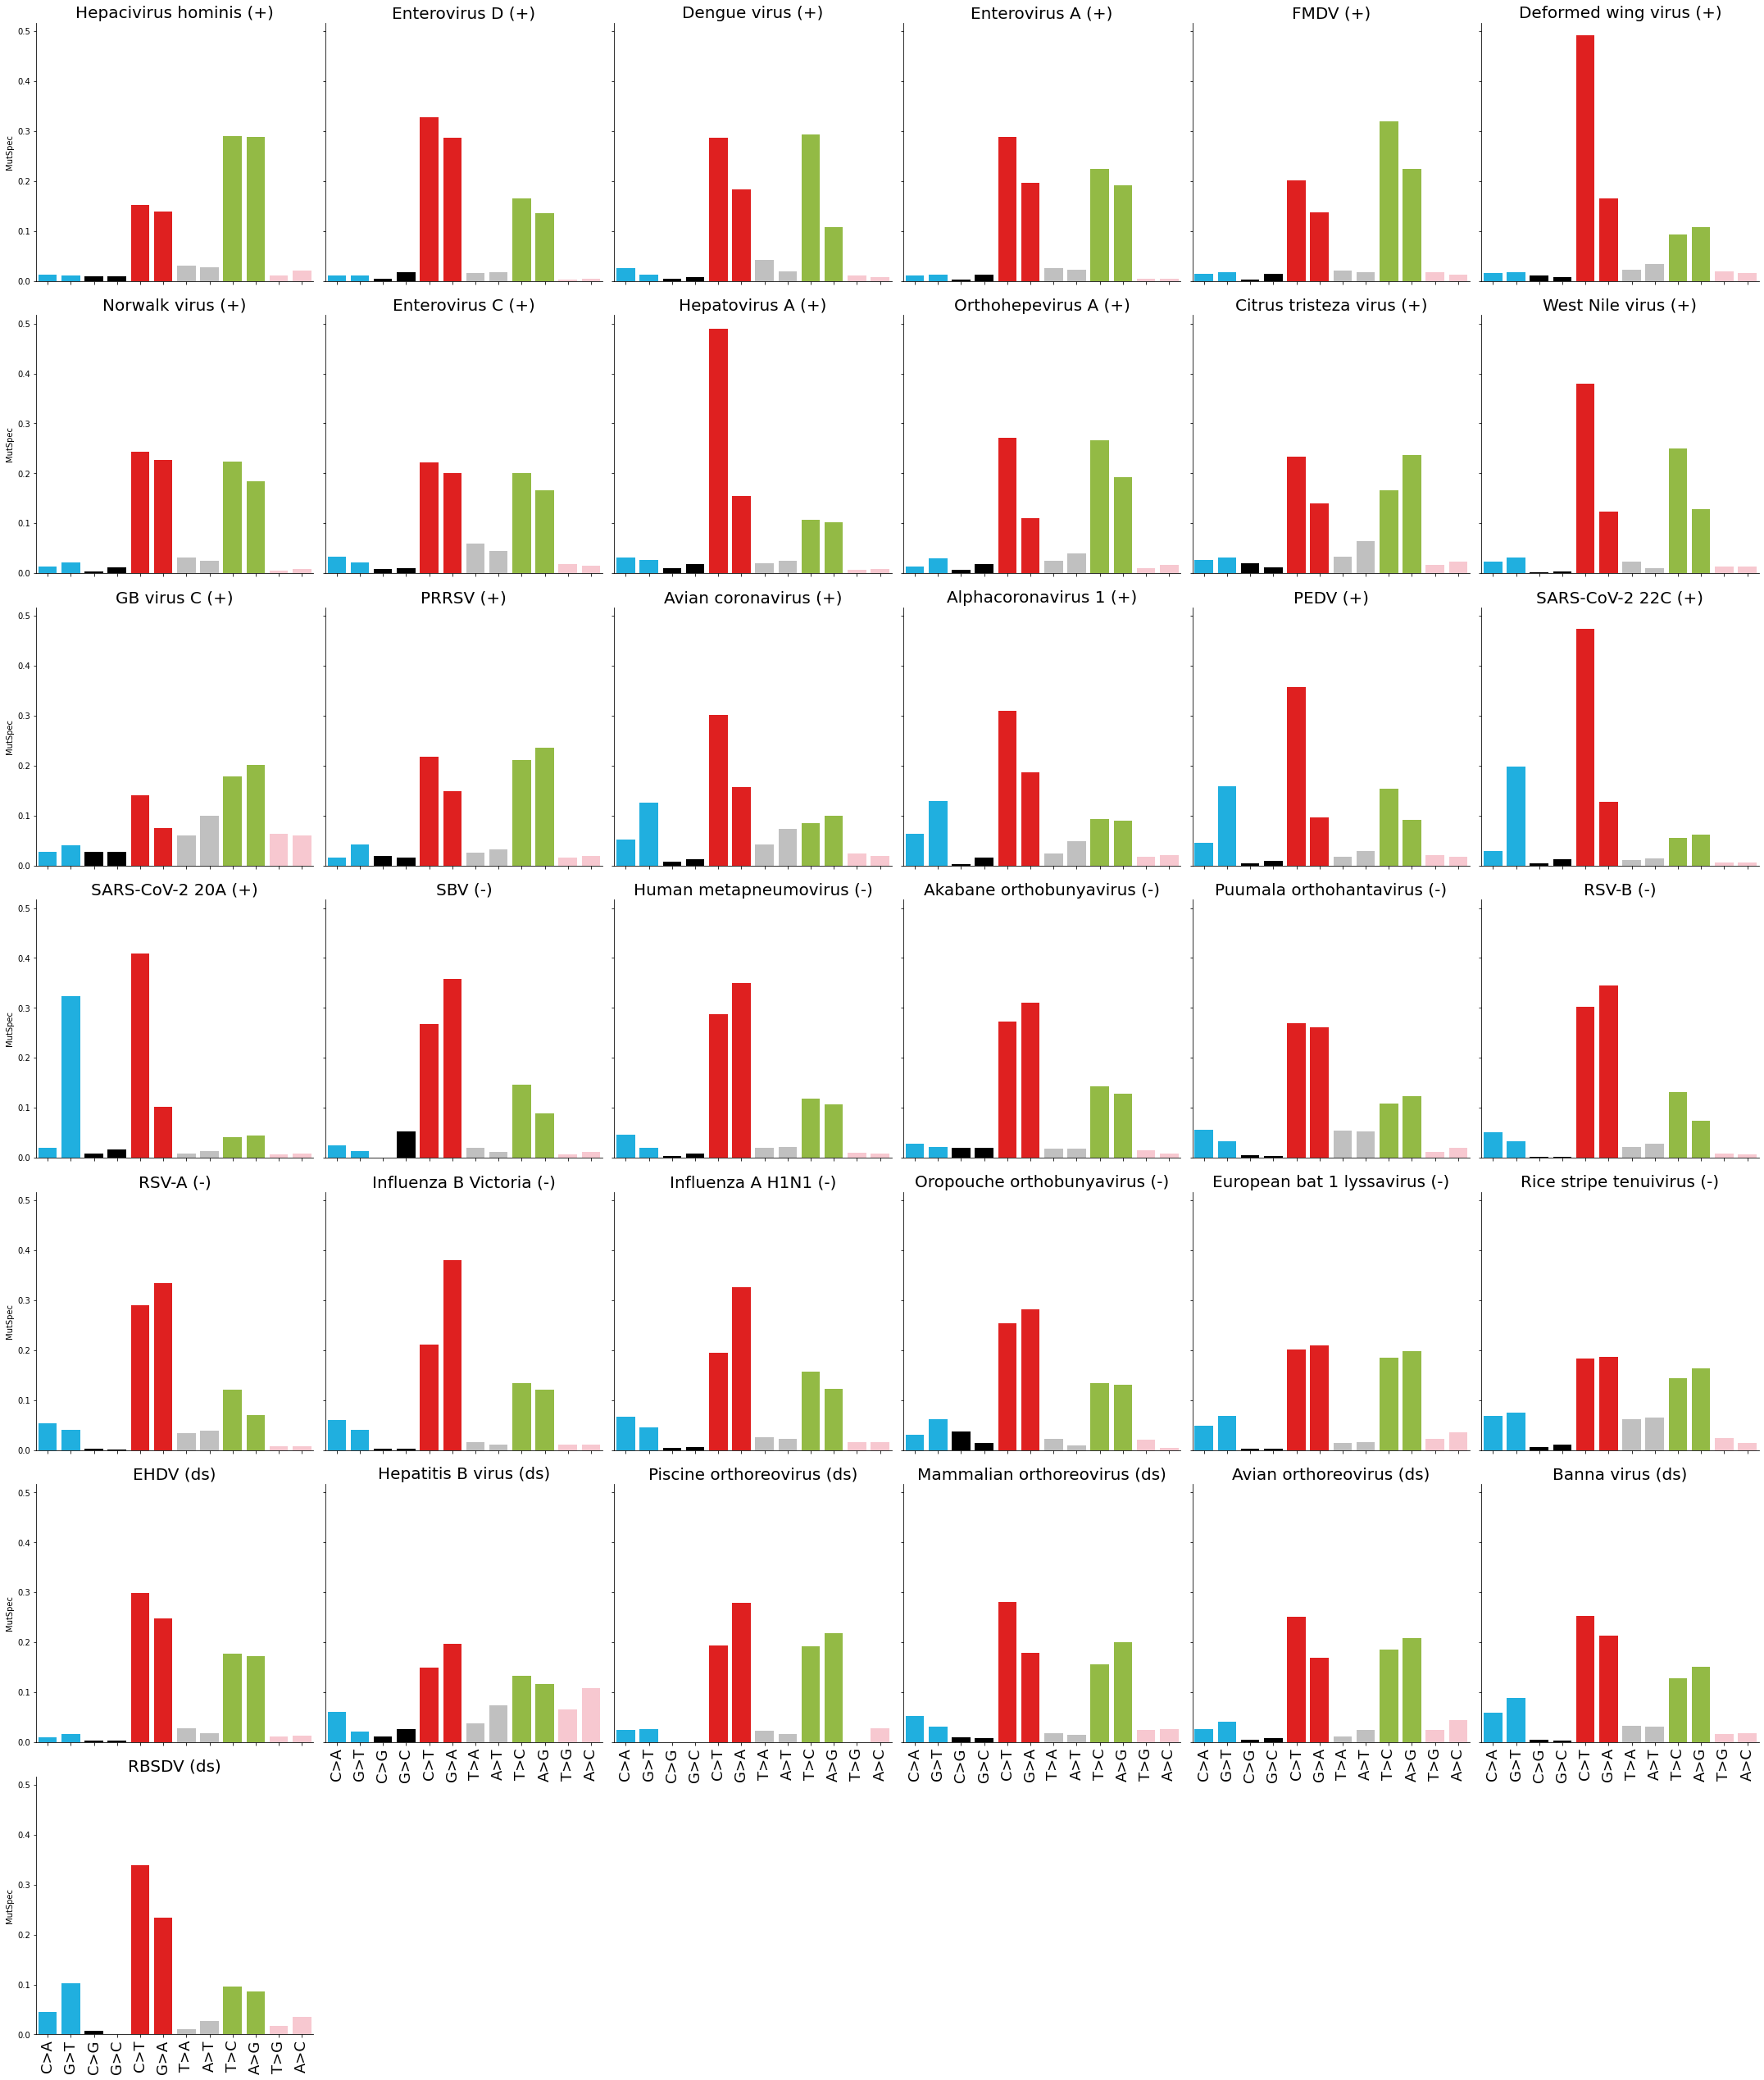

In [4]:
g = sns.catplot(spectra_long, x='Mut', y='MutSpec', col='label', 
            col_wrap=6, palette=color_mapping12, kind='bar', 
            order=color_mapping12.keys(), sharey=True)
g.set_titles('{col_name}')
g.set_xlabels('')
for ax in g.axes:
    ax.set_title(ax.get_title(), fontsize=20)
    ax.set_xticklabels(color_mapping12.keys(), fontsize=18, rotation=90)
g.savefig('./figures/spectra_dataset_barplots.pdf')

In [6]:
from utils import prepare_exp_aa_subst, plot_exp_heatmap, plot_aa_eq_freqs

In [43]:
spectra = pd.read_csv('./data/viral_spectra_dataset.csv')

In [49]:
flow[flow.Flow > cutoff].aa.to_list()

['Leu', 'Phe', 'Ile', 'Tyr', 'Val', 'Cys']

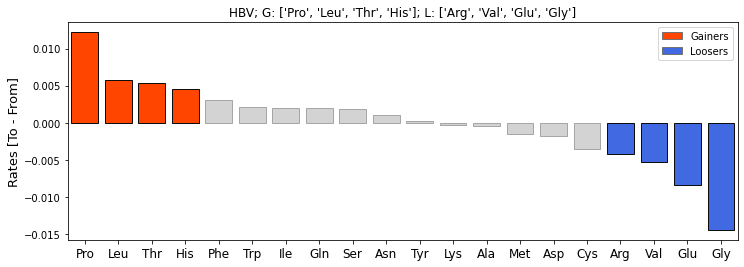

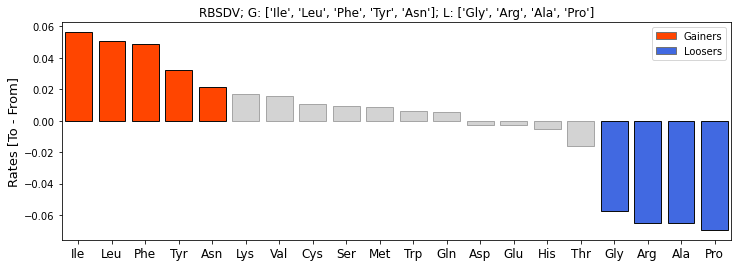

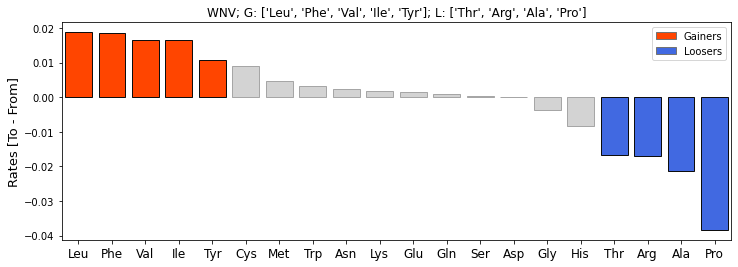

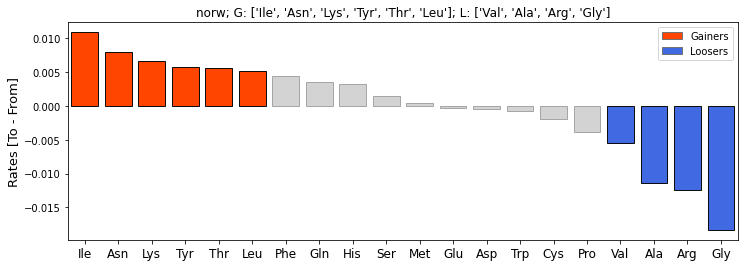

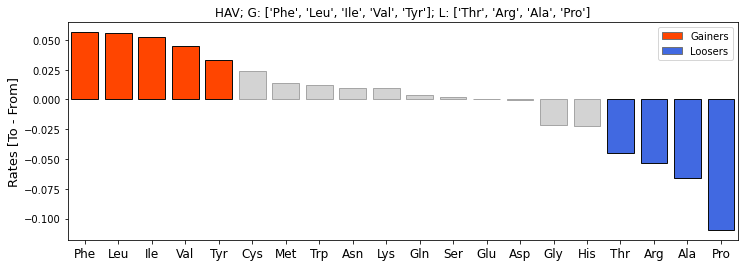

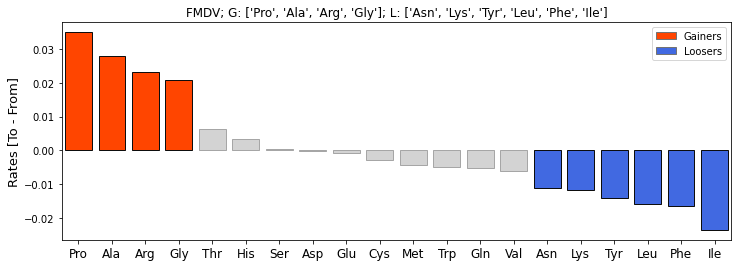

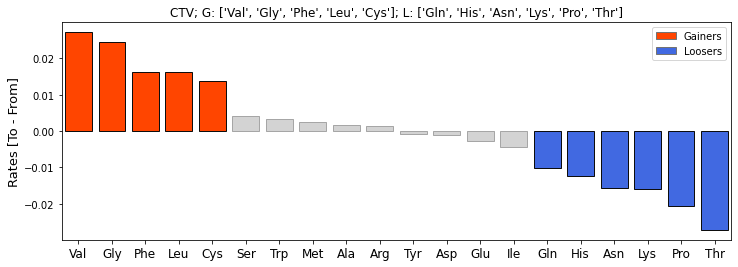

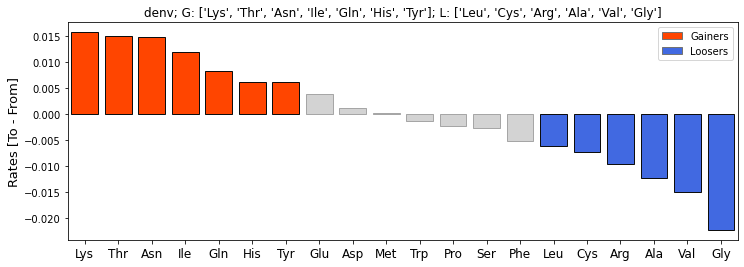

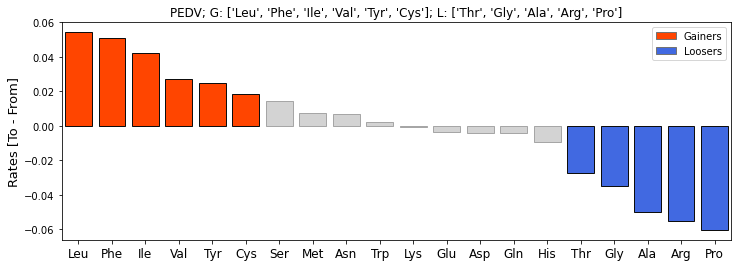

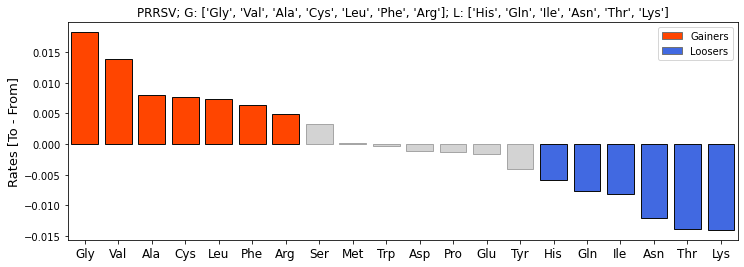

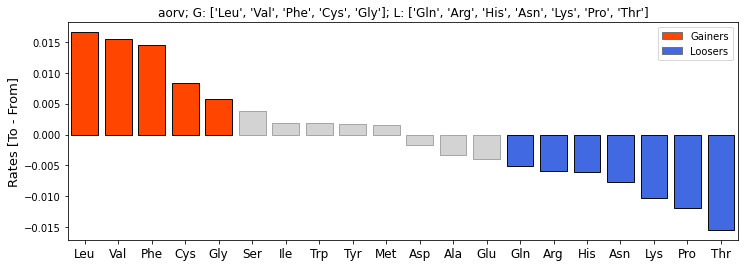

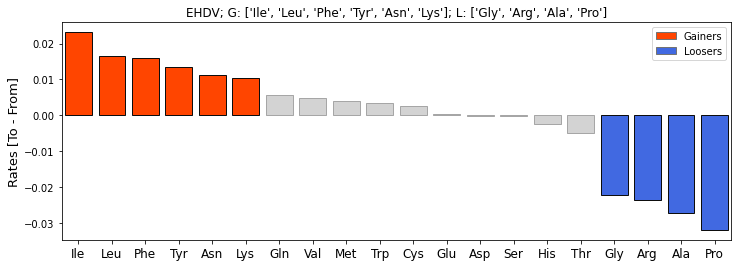

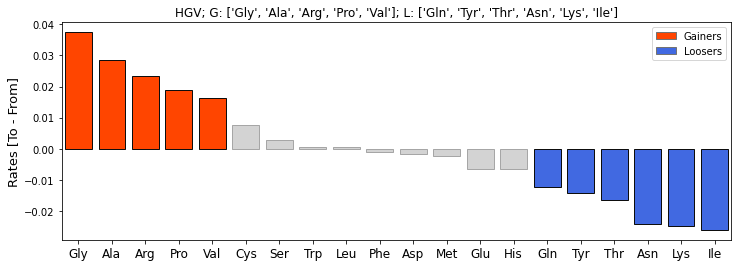

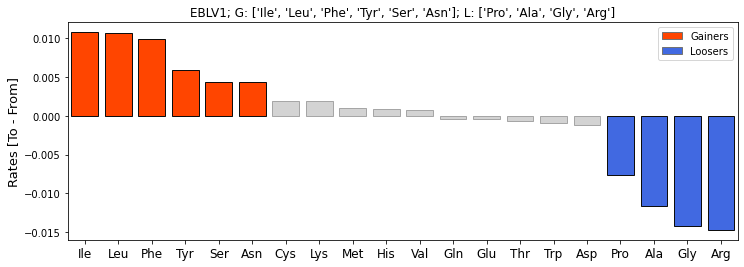

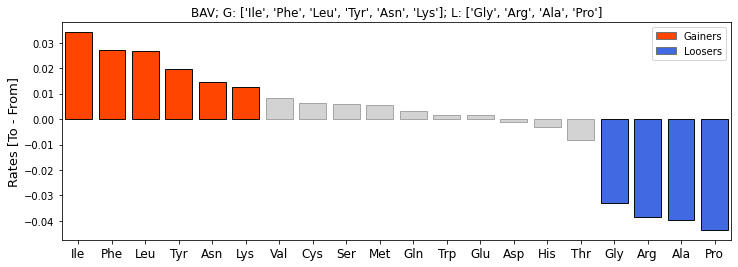

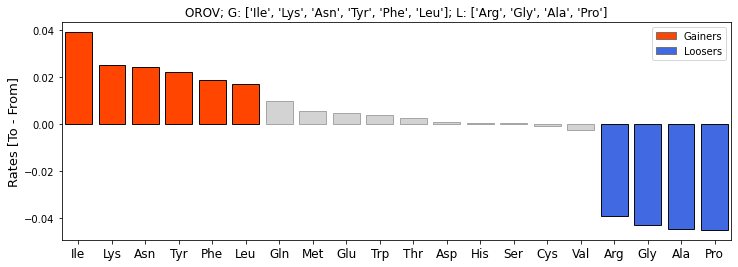

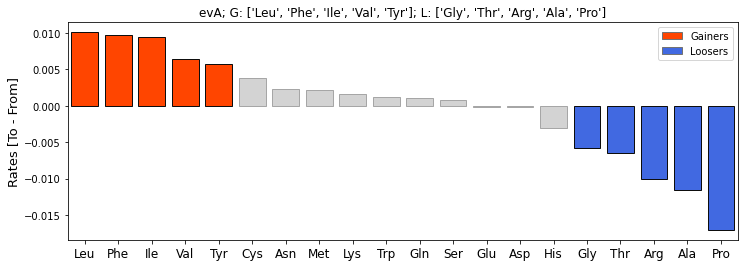

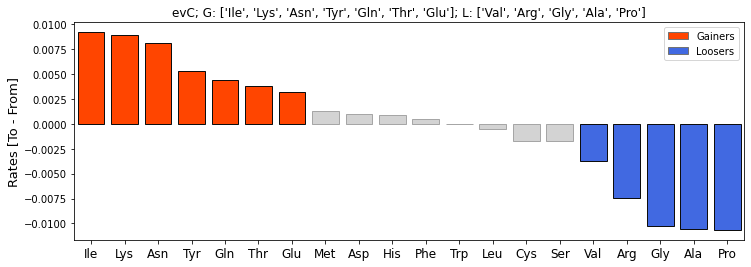

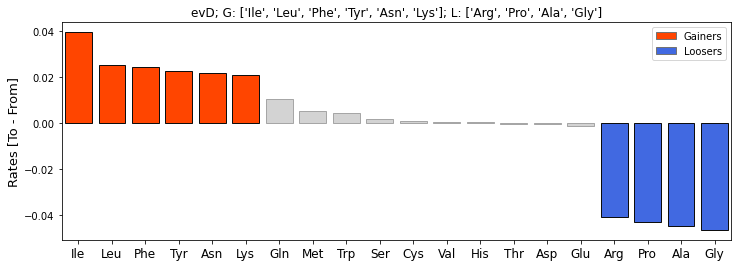

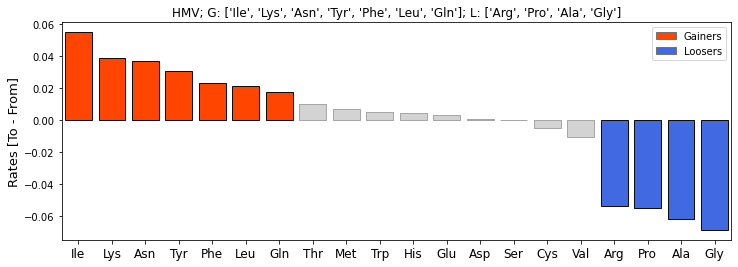

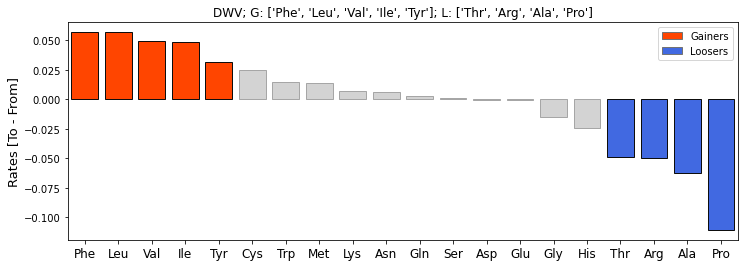

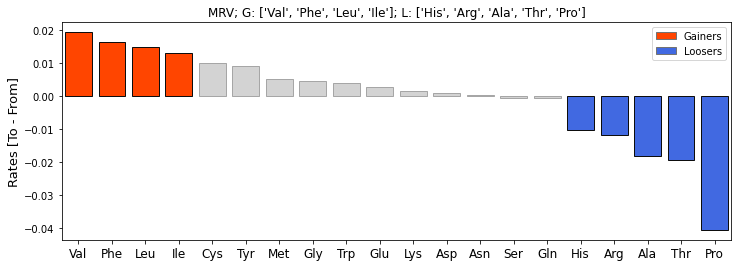

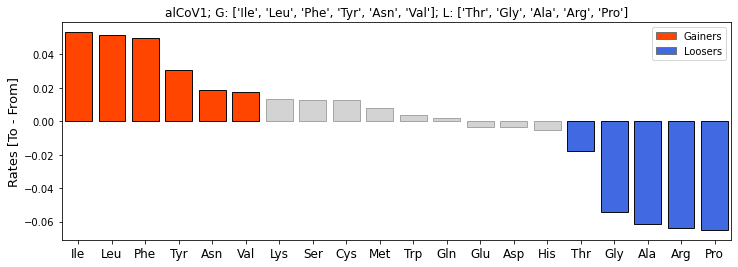

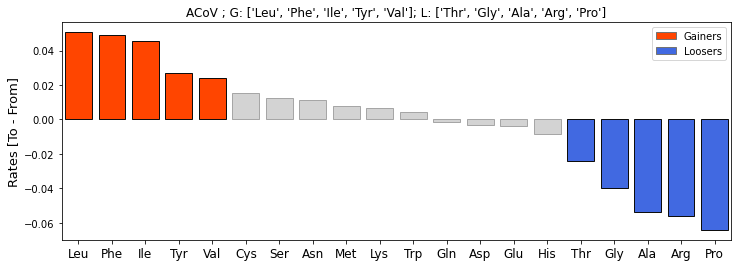

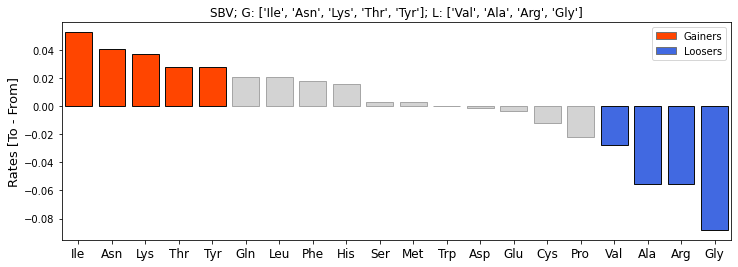

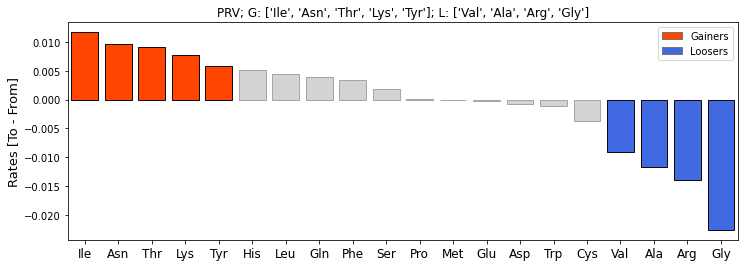

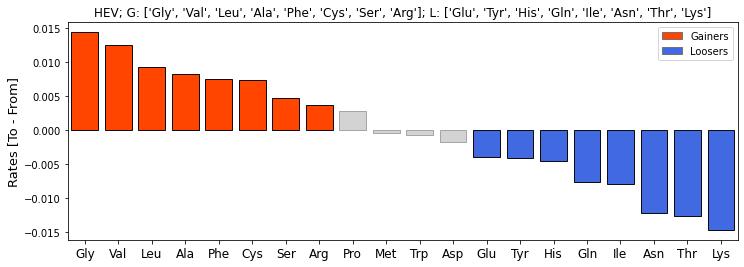

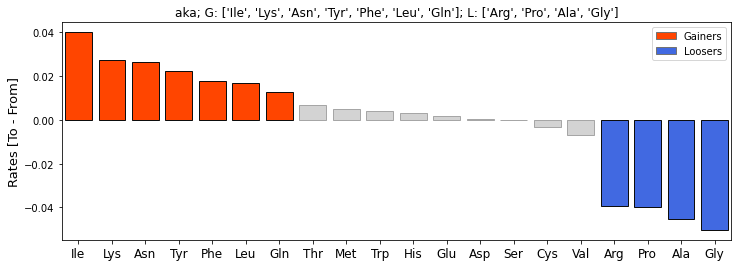

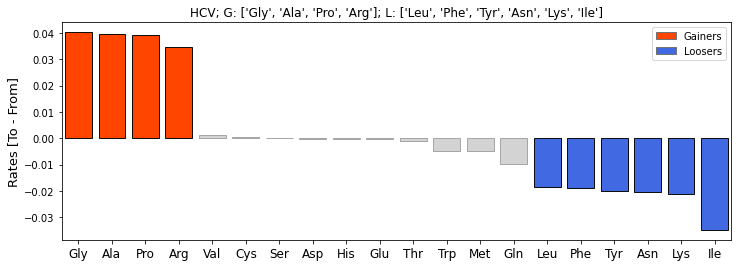

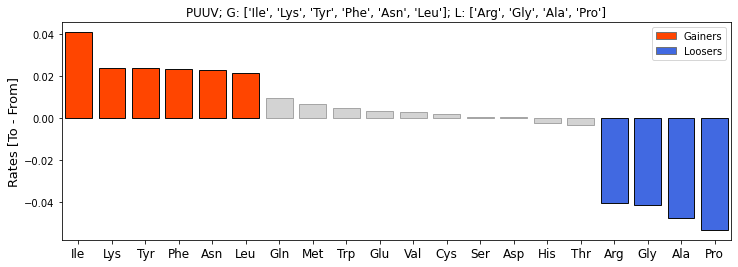

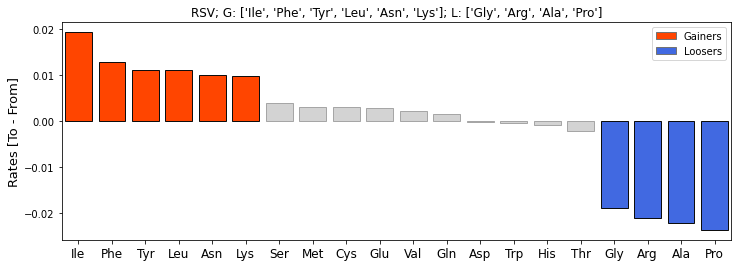

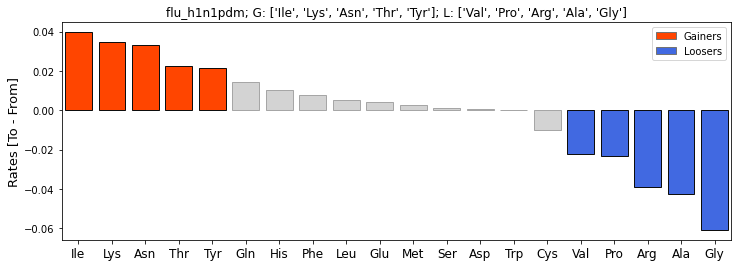

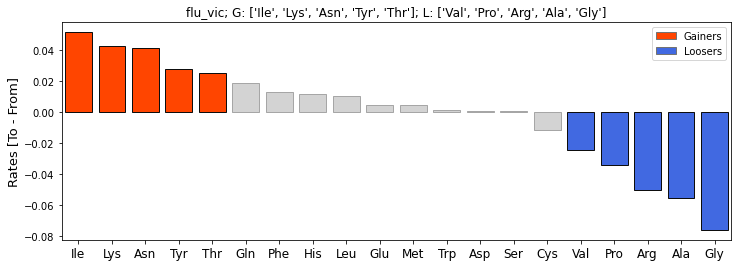

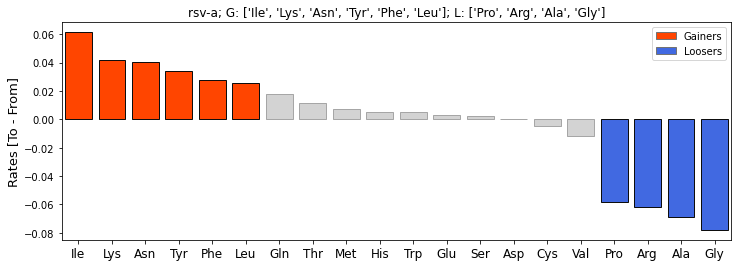

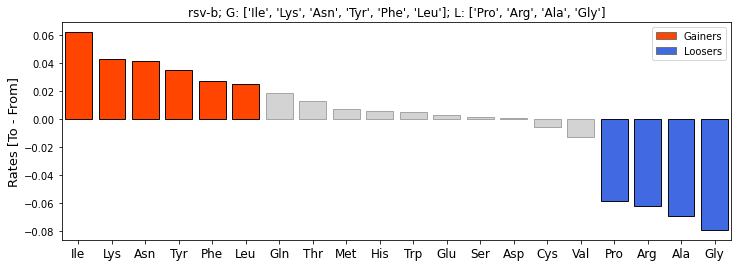

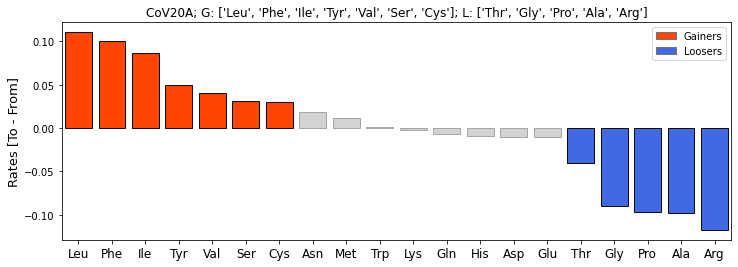

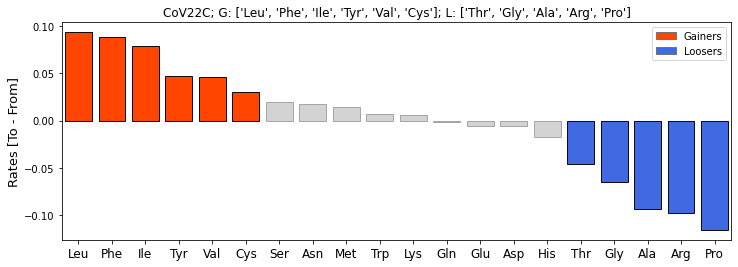

In [72]:
losers_gainers = []

for i in range(len(spectra)):
    ms12 = spectra.iloc[i, :12].reset_index()
    ms12.columns = ['Mut', 'rate']

    virusname = spectra.iloc[i]['virusname']
    taxname = spectra.iloc[i]['taxname']

    exp_aa_subst, exp_aa_subst_matrix = prepare_exp_aa_subst(ms12, gc=1)

    freqs_from = (exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()).copy()
    freqs_to = (exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()).copy()

    _freqs_to = (freqs_to / freqs_to.sum()).copy()
    _freqs_from = (freqs_from / freqs_from.sum()).copy()
    _freqs_to.index.name = 'aa'
    _freqs_from.index.name = 'aa'

    flow = (_freqs_to - _freqs_from).sort_values(ascending=False).rename('Flow').reset_index()

    plt.figure(figsize=(12, 4))
    ax = sns.barplot(flow, x='aa', y='Flow', color='lightgray', edgecolor=".65")

    cutoff = flow.Flow.abs().max() * 0.25

    losers_gainers.append({
        'virusname': virusname,
        'taxname': taxname,
        'gainers': flow[flow.Flow > cutoff].aa.to_list(),
        'losers': flow[flow.Flow < -cutoff].aa.to_list(),
    })

    for bar in ax.patches:
        if bar.get_height() > cutoff:
            bar.set_color('orangered')
            bar.set_edgecolor('0.05')
        elif bar.get_height() < -cutoff:
            bar.set_color('royalblue')
            bar.set_edgecolor('0.05')


    plt.legend([
        plt.Rectangle((0,0),1,1,fc="orangered", edgecolor = '0.45'), 
        plt.Rectangle((0,0),1,1,fc='royalblue', edgecolor = '0.45'),
        ],['Gainers', 'Loosers',], loc='upper right')

    plt.title(f"{virusname}; G: {losers_gainers[i]['gainers']}; L: {losers_gainers[i]['losers']}")
    plt.ylabel('Rates [To - From]', fontsize=13)
    plt.xlabel('')
    plt.xticks(fontsize=12)
    plt.show()

In [77]:
losers_gainers_df = pd.DataFrame(losers_gainers)
losers_gainers_df['gainers'] = losers_gainers_df['gainers'].apply(lambda x: '.'.join(x))
losers_gainers_df['losers'] = losers_gainers_df['losers'].apply(lambda x: '.'.join(x))
losers_gainers_df.to_csv('./data/losers_gainers.csv', index=False)
losers_gainers_df

,virusname,taxname,gainers,losers
0,HBV,Hepatitis B virus,Pro.Leu.Thr.His,Arg.Val.Glu.Gly
1,RBSDV,Rice black streaked dwarf virus,Ile.Leu.Phe.Tyr.Asn,Gly.Arg.Ala.Pro
2,WNV,West Nile virus,Leu.Phe.Val.Ile.Tyr,Thr.Arg.Ala.Pro
3,norw,Norwalk virus,Ile.Asn.Lys.Tyr.Thr.Leu,Val.Ala.Arg.Gly
4,HAV,Hepatovirus A,Phe.Leu.Ile.Val.Tyr,Thr.Arg.Ala.Pro
5,FMDV,Foot-and-mouth disease virus,Pro.Ala.Arg.Gly,Asn.Lys.Tyr.Leu.Phe.Ile
6,CTV,Citrus tristeza virus,Val.Gly.Phe.Leu.Cys,Gln.His.Asn.Lys.Pro.Thr
7,denv,Dengue virus,Lys.Thr.Asn.Ile.Gln.His.Tyr,Leu.Cys.Arg.Ala.Val.Gly
8,PEDV,Porcine epidemic diarrhea virus,Leu.Phe.Ile.Val.Tyr.Cys,Thr.Gly.Ala.Arg.Pro
9,PRRSV,Porcine reproductive and respiratory syndrome ...,Gly.Val.Ala.Cys.Leu.Phe.Arg,His.Gln.Ile.Asn.Thr.Lys


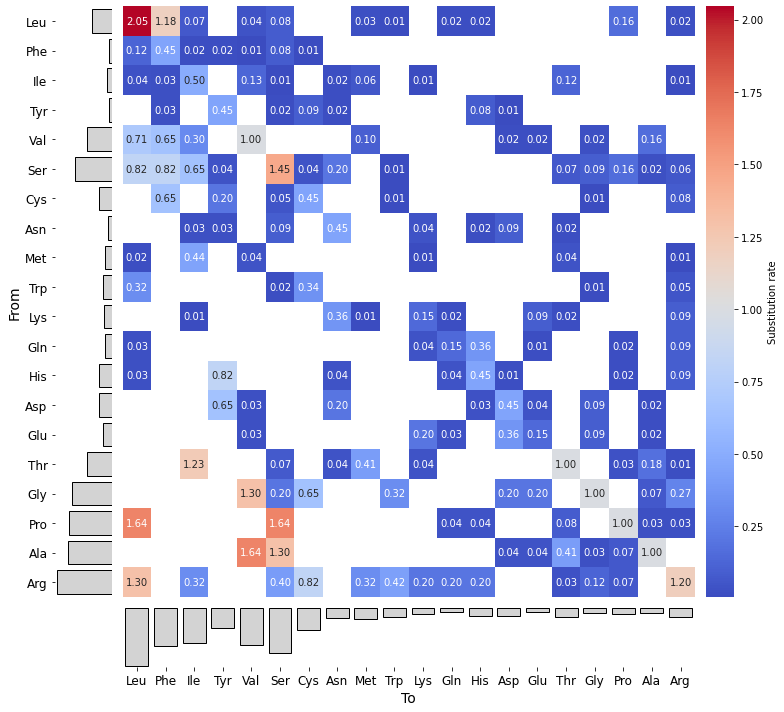

In [60]:
ms12 = spectra.iloc[-2, :12].reset_index()
ms12.columns = ['Mut', 'rate']

virusname = spectra.iloc[i]['virusname']
taxname = spectra.iloc[i]['taxname']

_, exp_aa_subst_matrix = prepare_exp_aa_subst(ms12, gc=1)

freqs_from = (exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()).copy()
freqs_to = (exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()).copy()

_freqs_to = (freqs_to / freqs_to.sum()).copy()
_freqs_from = (freqs_from / freqs_from.sum()).copy()
_freqs_to.index.name = 'aa'
_freqs_from.index.name = 'aa'

flow = (_freqs_to - _freqs_from).sort_values(ascending=False).rename('Flow').reset_index()

plot_exp_heatmap(exp_aa_subst_matrix.loc[flow.aa, flow.aa], '/tmp/bn.pdf', show=True, annot=True)